In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
#from tensorflow import keras
import keras
import matplotlib.pyplot as plt
from vis.visualization import visualize_saliency
from vis.visualization import get_num_filters
from vis.visualization import visualize_activation
from vis.utils import utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras import activations

/users/ai/u7ysrv/anaconda3/envs/samel/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/ai/u7ysrv/anaconda3/envs/samel/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/ai/u7ysrv/anaconda3/envs/samel/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/ai/u7ysrv/anaconda3/envs/samel

# 1. Loading Data 

## Read dataset

In [2]:
data = tf.keras.datasets.mnist

In [3]:
(trainX, trainY),(testX, testY) = data.load_data()

In [4]:
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

In [5]:
trainY = keras.utils.to_categorical(trainY, 10)
testY = keras.utils.to_categorical(testY, 10)

In [6]:
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

In [7]:
print(trainX.shape)

(60000, 28, 28, 1)


# Training

## Code for training

In [8]:
#Creates Sequential model using Keras
#Number of nodes is the same as number of features (different number of nodes were tried but it did not
#affect validation accuracy significantly)
lenet = keras.Sequential([
                            #Input layer:
                            keras.layers.Conv2D(20, 5, padding="same", input_shape=[28,28,1], use_bias=True),
                            #Hidden Layers:
                            keras.layers.Activation(activation="relu"),
                            keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                            keras.layers.Conv2D(50, 5, padding="same"),
                            keras.layers.Activation(activation="relu"),
                            keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                            keras.layers.Flatten(),
                            keras.layers.Dense(500),
                            keras.layers.Activation(activation="relu"),
                            keras.layers.Dense(10, name='vis',use_bias=True),
                            #Output layer
                            keras.layers.Activation(activation="softmax"),
                        ])

In [9]:
#lenets = [keras.models.clone_model(lenet),keras.models.clone_model(lenet),keras.models.clone_model(lenet),keras.models.clone_model(lenet),keras.models.clone_model(lenet),keras.models.clone_model(lenet)]

In [10]:
classifier_number = 5
lenets = [keras.models.clone_model(lenet)]
for i in range(1,classifier_number):
    lenets.append(keras.models.clone_model(lenet))

In [11]:
#Compiles sequential model
#Using learning rate 0.01
#Loss function will be categorical crossentropy
lenet.compile(
                optimizer=keras.optimizers.SGD(lr=0.01),
                loss = 'categorical_crossentropy',
                metrics = ['accuracy']
                )
#Trains network over a number of epochs and evaluates network agains validation data
#after each epoch
lenetEpochHistory = lenet.fit(trainX, trainY, epochs = 5, validation_data = (testX, testY))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 17s 278us/step - loss: 0.4151 - acc: 0.8797 - val_loss: 0.1164 - val_acc: 0.9649
Epoch 2/5
60000/60000 [==============================] - 12s 201us/step - loss: 0.1066 - acc: 0.9678 - val_loss: 0.0704 - val_acc: 0.9784
Epoch 3/5
60000/60000 [==============================] - 12s 204us/step - loss: 0.0751 - acc: 0.9771 - val_loss: 0.0590 - val_acc: 0.9817
Epoch 4/5
60000/60000 [==============================] - 12s 201us/step - loss: 0.0605 - acc: 0.9818 - val_loss: 0.0529 - val_acc: 0.9828
Epoch 5/5
60000/60000 [==============================] - 12s 206us/step - loss: 0.0511 - acc: 0.9841 - val_loss: 0.0459 - val_acc: 0.9839


In [12]:
#Compiles sequential model
#Using learning rate 0.01
#Loss function will be categorical crossentropy
for model in lenets:
    model.compile(
                    optimizer=keras.optimizers.SGD(lr=0.01),
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy']
                    )
#Trains network over a number of epochs and evaluates network agains validation data
#after each epoch
for model in lenets:
    model.fit(trainX, trainY, epochs = 5, validation_data = (testX, testY))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 13s 210us/step - loss: 0.3838 - acc: 0.8901 - val_loss: 0.1244 - val_acc: 0.9626
Epoch 2/5
60000/60000 [==============================] - 12s 202us/step - loss: 0.1075 - acc: 0.9685 - val_loss: 0.1087 - val_acc: 0.9627
Epoch 3/5
60000/60000 [==============================] - 12s 203us/step - loss: 0.0758 - acc: 0.9766 - val_loss: 0.0571 - val_acc: 0.9816
Epoch 4/5
60000/60000 [==============================] - 12s 203us/step - loss: 0.0605 - acc: 0.9810 - val_loss: 0.0447 - val_acc: 0.9854
Epoch 5/5
60000/60000 [==============================] - 12s 204us/step - loss: 0.0501 - acc: 0.9849 - val_loss: 0.0541 - val_acc: 0.9813
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 13s 209us/step - loss: 0.4479 - acc: 0.8725 - val_loss: 0.1281 - val_acc: 0.9616
Epoch 2/5
60000/60000 [==============================] - 12s 200us/step 

# General Evaluation

In [13]:
#Predicting Label:

print(np.argmax(lenet.predict(testX)[100]))
print(np.argmax(testY[100]))

6
6


10000/10000 [==============================] - 1s 80us/step
Lenet accuracy:  0.9839
Lenet loss:  0.045863325390056706


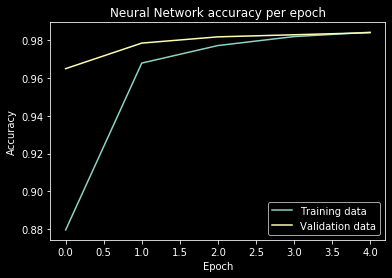

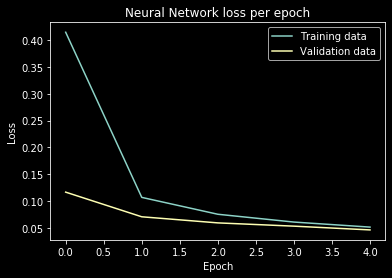

In [14]:
#Get accuracy for lenet
sequentialLoss, sequentialAccuracy = lenet.evaluate(testX, testY)
print('Lenet accuracy: ', sequentialAccuracy)
print('Lenet loss: ', sequentialLoss)

plt.style.use('dark_background')
plt.plot(lenetEpochHistory.history['acc'])
plt.plot(lenetEpochHistory.history['val_acc'])
plt.title('Neural Network accuracy per epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training data', 'Validation data'])
plt.show()

plt.style.use('dark_background')
plt.plot(lenetEpochHistory.history['loss'])
plt.plot(lenetEpochHistory.history['val_loss'])
plt.title('Neural Network loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training data', 'Validation data'])
plt.show()

# Saliency

In [15]:
#This line outputs the layer_idx that the saliency is meant to be extracted from. (Usually the output layer pre-activation)
utils.find_layer_idx(lenet, 'vis')

9

In [16]:
#Check if that layer is correct by checking if the number of nodes matches the number of outputs
get_num_filters(lenet.layers[9])

10

127.66993


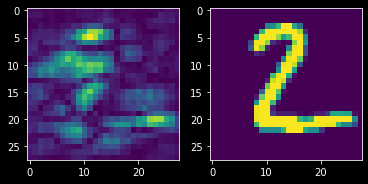

In [17]:
#Check if the saliency map is working for the singular network
input_idx = 1
fig, ax = plt.subplots(nrows=1, ncols=2)
saliency_map = visualize_saliency(model = lenet,layer_idx = 9, filter_indices = np.argmax(testY[input_idx]), seed_input = testX[input_idx])
ax[0].imshow(saliency_map.reshape(28,28),interpolation='nearest')
ax[1].imshow(testX[input_idx].reshape(28,28))
print(np.sum(saliency_map))
plt.show()

In [18]:
#This prints out the pre-activation outputs for the output layer (for curiosity)
intermediate_layer_model = keras.Model(inputs=lenet.input,
                                 outputs=lenet.get_layer("vis").output)
intermediate_output = intermediate_layer_model.predict(testX)[input_idx]
print(max(intermediate_output))
print(lenet.predict(testX)[input_idx])

17.762522
[7.2112664e-07 3.8382081e-05 9.9995923e-01 5.6524959e-07 1.6890947e-10
 7.4681705e-11 1.9684887e-08 7.6446599e-11 1.0190720e-06 2.4528426e-13]


In [19]:
#Function to generate multiple saliency maps
def generate_saliency_maps(classifiers,classifier_input,output_node,visualised_layer):
    saliency_maps = []
    for classifier in classifiers:
        saliency_maps.append(visualize_saliency(model = classifier,layer_idx = visualised_layer, filter_indices = output_node, seed_input = classifier_input))
    return(saliency_maps)    
    

In [68]:
#Function to visualise the multiple saliency maps
def visualize_saliency_maps(classifier_input,saliency_maps):
    fig, ax = plt.subplots(nrows=1, ncols=len(saliency_maps)+1, figsize = (15,15))
    i = 1
    for s_map in saliency_maps:
        ax[i].imshow(s_map)
        i = i+1
    ax[0].imshow(classifier_input)
    plt.show()

In [69]:
# Compute difference of saliency maps
def generate_uncertainty_map(saliency_maps):
    return(np.std(saliency_maps,axis=0)/np.average(saliency_maps,axis=0))

In [78]:
# Wrapper function to arrive at ratio output from classifiers and input
def calculate_uncertainty(classifiers,classifier_input,output_node,visualised_layer):
    
    saliency_maps = generate_saliency_maps(classifiers = classifiers,
                                  classifier_input = classifier_input,
                                  output_node = output_node,
                                  visualised_layer = visualised_layer)
    
    uncertainty_map = generate_uncertainty_map(saliency_maps)
    
    return(np.average(uncertainty_map))


In [79]:
# Generate saliency maps examples
input_idx = 1
maps = generate_saliency_maps(classifiers = lenets,
                              classifier_input = testX[input_idx],
                              output_node = np.argmax(testY[input_idx]),
                              visualised_layer = 9)

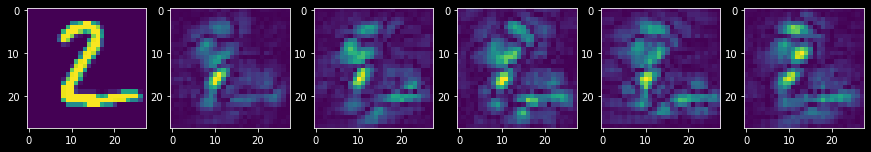

In [80]:
# Visualise saliency maps examples
visualize_saliency_maps(classifier_input = testX[input_idx].reshape(28,28),
                        saliency_maps = maps)

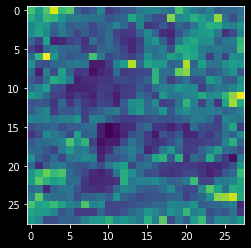

In [81]:
# Visualise uncertainty map example
uncertainty_map = generate_uncertainty_map(maps)
plt.imshow(uncertainty_map)
plt.show()

In [82]:
# Compute the average difference value for each pixel (uncertainty)
np.average(saliency_map_difference)

0.5616534

In [88]:
# Generating example using wrapper function
input_idx = 4
uncertainty = calculate_uncertainty(classifiers = lenets,
                              classifier_input = testX[input_idx],
                              output_node = np.argmax(testY[input_idx]),
                              visualised_layer = 9)
print(uncertainty)

0.54157114


In [26]:
#Output images that were misclassified by the singular classifier
idx = 0
for i in lenet.predict(testX):
    if (np.argmax(i) != np.argmax(testY[idx])):
        print(idx)
    idx = idx + 1

259
290
340
445
495
582
684
689
720
938
947
951
965
1003
1014
1039
1182
1226
1232
1242
1247
1260
1289
1299
1319
1326
1364
1393
1500
1522
1530
1609
1681
1709
1717
1721
1737
1754
1878
1901
1955
2016
2035
2098
2109
2118
2130
2135
2182
2189
2272
2369
2387
2414
2422
2454
2462
2488
2526
2597
2648
2654
2743
2771
2810
2896
2953
2995
3030
3073
3130
3422
3503
3520
3558
3597
3702
3762
3767
3796
3808
3811
3853
3869
3893
3902
3906
3951
3985
4075
4078
4102
4163
4176
4224
4256
4271
4306
4360
4369
4497
4536
4571
4578
4639
4740
4761
4807
4814
4823
4860
4874
4880
4956
5199
5331
5600
5642
5842
5887
5937
5955
5972
5973
5981
5982
5985
5997
6011
6023
6042
6059
6505
6555
6571
6572
6576
6597
6651
6783
6847
6926
8062
8094
8316
8408
9009
9015
9019
9024
9587
9634
9642
9664
9679
9698
9729
9770
9792
9811
9888
